Trabalho prático 3 - Sistemas de Informação - Inteligência Artificial e Aprendizagem de Máquina - Júlio Cézar da Silva Costa

Grupo: Sérgio Teixeira da Costa Filho, Pedro Henrique de Souza Marques, Kelly Cíntia Soares Gomes

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [ ]:
!pip install kaggle
import os
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.model_selection import train_test_split

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d trainingdatapro/age-detection-human-faces-18-60-years

Dataset URL: https://www.kaggle.com/datasets/trainingdatapro/age-detection-human-faces-18-60-years
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
 94% 318M/337M [00:01<00:00, 163MB/s]
100% 337M/337M [00:01<00:00, 215MB/s]


In [ ]:
zip_file_name = 'age-detection-human-faces-18-60-years.zip'
unzip_path = 'age_dataset'

if os.path.exists(zip_file_name):
  os.makedirs(unzip_path, exist_ok=True)
  with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(unzip_path)
  print(f"Dataset descompactado para {unzip_path}")
else:
  print(f"Erro: {zip_file_name} não encontrado")

Dataset descompactado para age_dataset


Coloca age_detection no train

In [ ]:
image_dir = os.path.join(unzip_path, 'train')
csv_path = os.path.join(image_dir, 'age_detection.csv')

if not os.path.exists(image_dir):
  print(f"Erro: Diretório de imagens não encontrado: {image_dir}")
else:
  print(f"Diretório de imagens encontrado: {image_dir}")

try:
  df = pd.read_csv(csv_path)
  print("Arquivo CSV carregado com sucesso.")
except FileNotFoundError:
  print(f"Erro: Arquivo CSV não encontrado: {csv_path}")
  df = None

IMAGE_SIZE = (512, 512)
BATCH_SIZE = 60

if df is not None and not df.empty:
  print("Preparando geradores de dados...")

  try:
    df['age'] = df['age'].replace({'18-20': 18, '21-30': 21, '31-40': 31, '41-50': 41, '51-60': 51})
    df['file'] = df['file'].str.replace('train/', '').str.replace('test/', '')
    display(df.head())
    train_df, validation_df = train_test_split(df, test_size=0.2, random_state=42)
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=image_dir,
        x_col='file',
        y_col='age',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='raw',
        color_mode='rgb',
        subset=None
    )

    validation_generator = validation_datagen.flow_from_dataframe(
        dataframe=validation_df,
        directory=image_dir,
        x_col='file',
        y_col='age',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='raw',
        color_mode='rgb',
        subset=None
    )

    print("Geradores de dados criados com sucesso.")
  except KeyError as e:
    print(f"Erro: Coluna esperada ausente no dataframe CSV: {e}")
    print("Verifique os nomes das colunas no seu arquivo CSV (por exemplo, 'File Name', 'Age')")
    train_generator = None
    validation_generator = None
  except FileNotFoundError as e:
    print(f"Erro: Diretório especificado em flow_from_dataframe não encontrado: {e}")
    print("Verifique se o caminho 'directory' aponta para o local correto das imagens.")
    train_generator = None
    validation_generator = None
  except Exception as e:
    print(f"Ocorreu um erro inesperado durante a preparação dos dados: {e}")
    train_generator = None
    validation_generator = None
else:
  print("Pulando a preparação dos dados porque o dataframe CSV não foi carregado.")
  train_generator = None
  validation_generator = None

Diretório de imagens encontrado: age_dataset/train
Arquivo CSV carregado com sucesso.
Preparando geradores de dados...


/tmp/ipython-input-3270850369.py:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['age'] = df['age'].replace({'18-20': 18, '21-30': 21, '31-40': 31, '41-50': 41, '51-60': 51})


,file,age,split
0,18-20/0.jpg,18,train
1,18-20/1.jpg,18,train
2,18-20/2.jpg,18,train
3,18-20/3.jpg,18,train
4,18-20/4.jpg,18,train


Found 101 validated image filenames.
Found 24 validated image filenames.
Geradores de dados criados com sucesso.


/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 19 invalid image filename(s) in x_col="file". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 6 invalid image filename(s) in x_col="file". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 510, 510, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 255, 255, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 253, 253, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 126, 126, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 124, 124, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 492032)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    62,980,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,073,601 (240.61 MB)

 Trainable params: 63,073,601 (240.61 MB)

 Non-trainable params: 0 (0.00 B)

Treinamento do modelo

In [ ]:
if train_generator is not None and validation_generator is not None:
  print("Iniciando treinamento do modelo...")
  history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples // BATCH_SIZE,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples // BATCH_SIZE
  )
  print("Treinamento do modelo finalizado.")
else:
  print("Pulando o treinamento porque os geradores de dados não estavam disponíveis.")

Iniciando treinamento do modelo...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 58s 58s/step - loss: 1251.8667 - mae: 33.1515 - val_loss: 7816.7134 - val_mae: 85.3074
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 43s 43s/step - loss: 7729.4878 - mae: 83.5134 - val_loss: 316.1694 - val_mae: 13.9565
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 43s 43s/step - loss: 351.8846 - mae: 14.9997 - val_loss: 1269.2290 - val_mae: 33.4226
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 47s 47s/step - loss: 1191.8932 - mae: 32.2088 - val_loss: 1269.1272 - val_mae: 33.4294
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 116s 116s/step - loss: 1116.2853 - mae: 31.1830 - val_loss: 1245.3260 - val_mae: 33.0800
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 30s 30s/step - loss: 1267.5092 - mae: 33.3116 - val_loss: 1238.5472 - val_mae: 32.9806
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 55s 55s/step - loss: 1236.2982 - mae: 32.8993 - val_loss: 1221.5599 - val_mae: 32.7279
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 30s 30s/step - loss: 1029.1368 - mae: 29.7953 - val_loss: 1137.2223 - val_mae: 31.4380
Epoch 9/10
1/1 ━

Avaliação do modelo

In [ ]:
if 'model' in locals() and model is not None and validation_generator is not None:
  print("Avaliando o modelo treinado...")
  evaluation_results = model.evaluate(validation_generator, steps=validation_generator.samples // BATCH_SIZE)
  print(f"Perda de Validação (Erro Quadrático Médio): {evaluation_results[0]:.4f}")
  print(f"MAE de Validação (Erro Absoluto Médio): {evaluation_results[1]:.4f}")
else:
  print("Avaliação do modelo finalizado.")

Avaliando o modelo treinado...
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 550.4076 - mae: 20.3150
Perda de Validação (Erro Quadrático Médio): 550.4076
MAE de Validação (Erro Absoluto Médio): 20.3150


Arrasta o arquivo "age_detection.csv" para a pasta de test

Previsão

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# 1 Definir o caminho para o diretório de dados de teste e o arquivo CSV de teste
# Estes caminhos são baseados na suposição de que o dataset foi descompactado corretamente
# NOTA: Ajuste os caminhos se a estrutura do seu dataset descompactado for diferente
unzip_path = 'age_dataset'  # Caminho base onde o dataset foi descompactado
test_dir = os.path.join(unzip_path, 'test')  # Diretório esperado para imagens de teste
test_csv_path = os.path.join(test_dir, "age_detection.csv")  # Caminho esperado para o CSV de teste

# 2 Carregar o arquivo CSV de teste em um DataFrame pandas.
# Este CSV geralmente contém apenas os nomes dos arquivos das imagens de teste.
try:
    test_df = pd.read_csv(test_csv_path)

    # Converter a coluna 'age' para um tipo numérico (mapeando faixas etárias para valores representativos)
    test_df['age'] = test_df['age'].replace({
        '18-20': 18,
        '21-30': 21,
        '31-40': 31,
        '41-50': 41,
        '51-60': 51
    })

    # Ajustar nomes dos arquivos (remover prefixos indesejados)
    test_df['file'] = (
        test_df['file']
        .str.replace('train/', '', regex=False)
        .str.replace('test/', '', regex=False)
    )

    # Filtrar o DataFrame para manter apenas os registros onde 'split' é "test"
    if 'split' in test_df.columns:
        test_df = test_df[test_df['split'] == 'test'].copy()

    print("Arquivo CSV de teste carregado com sucesso.")
    display(test_df.head())

except FileNotFoundError:
    print(f"Erro: Arquivo CSV de teste não encontrado em {test_csv_path}")
    print("Certifique-se de que o dataset foi baixado e descompactado corretamente e que o CSV de teste existe.")
    # Definir test_df como None se o carregamento falhar
    test_df = None

Arquivo CSV de teste carregado com sucesso.


/tmp/ipython-input-3224497475.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df['age'] = test_df['age'].replace({


,file,age,split
25,18-20/25.jpg,18,test
26,18-20/26.jpg,18,test
27,18-20/27.jpg,18,test
28,18-20/28.jpg,18,test
29,18-20/29.jpg,18,test


In [ ]:
if test_df is not None and not test_df.empty:
    print("Criando gerador de dados de teste ... ")

    # Instanciar ImageDataGenerator para o conjunto de teste. Apenas redimensionamento é aplicado.
    test_datagen = ImageDataGenerator(rescale=1./255)  # Normalizar valores de pixel

    # Usar flow_from_dataframe para criar o gerador de teste
    try:
        test_generator = test_datagen.flow_from_dataframe(
            dataframe=test_df,
            directory=test_dir,   # Diretório onde as imagens de teste estão localizadas
            x_col='file',         # Ajuste se o nome da coluna for diferente
            y_col=None,           # Sem rótulos para o conjunto de teste
            target_size=IMAGE_SIZE,
            batch_size=BATCH_SIZE,
            class_mode=None,      # Sem rótulos para o conjunto de teste
            color_mode='rgb',
            shuffle=False         # Não embaralhar para previsão
        )
        print("Gerador de dados de teste criado com sucesso.")

        # 4. Gerar previsões no conjunto de teste.
        # Usar o modelo treinado para prever a idade de cada imagem no conjunto de teste
        if 'model' in locals() and model is not None:
            print("Gerando previsões no conjunto de teste ... ")

            # Prever idades usando o modelo treinado
            # steps: número de passos (lotes) a serem executados para previsão.
            # Adicionar +1 para garantir que todas as amostras sejam incluídas,
            # mesmo que o último lote seja menor que BATCH_SIZE.
            predictions = model.predict(
                test_generator,
                steps=test_generator.samples // BATCH_SIZE + 1
            )

            print("Previsões geradas com sucesso.")
        else:
            print("Pulando a previsão porque o modelo não está disponível.")
            predictions = None # Definir previsões como None se o modelo não estiver disponivel

    except KeyError as e:
      print(f"Erro: Coluna esperada ausente no dataframe de teste: {e}")
      print("Verifique os nomes das colunas no seu arquivo CSV de teste.")
      test_generator = None
      predictions = None
    except FileNotFoundError as e:
      print(f"Erro: Diretorio especificado em flow_from_dataframe para imagens de teste nao encontrado: {e}")
      print("Verifique se o caminho 'directory' aponta para o local correto das imagens de teste.")
      test_generator = None
      predictions = None
    except Exception as e:
      print(f"Ocorreu um erro inesperado durante a criação do gerador de teste ou previsão: {e}")
      test_generator = None
      predictions = None

else:
  print("Pulando a criaçãc do gerador de dados de teste e previsão devido a falha no carregamento do dataframe CSV de teste.")
  test_generator = None
  predictions = None

Criando gerador de dados de teste ... 
Found 25 validated image filenames.
Gerador de dados de teste criado com sucesso.
Gerando previsões no conjunto de teste ... 


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Previsões geradas com sucesso.


Criando DataFrame de submissão ... 
DataFrame de submissão criado.


,File Name,Age
25,18-20/25.jpg,14
26,18-20/26.jpg,15
27,18-20/27.jpg,8
28,18-20/28.jpg,17
29,18-20/29.jpg,15


Salvando DataFrame de submissão em submission.csv ...
Arquivo de submissão 'submission.csv' criado com sucesso.

Visualizando algumas previsões:


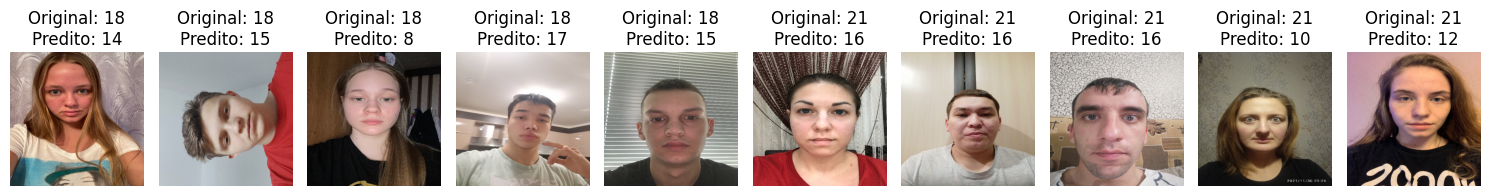

In [ ]:
if predictions is not None and test_df is not None and not test_df.empty:
    print("Criando DataFrame de submissão ... ")

    # As previsões de model.predict serão um array numpy.
    # Como a camada de saída tem 1 neurônio, a forma será (n_amostras_teste, 1).
    # Achatar o array para obter um array 1D de idades previstas.
    predicted_ages = predictions.flatten()

    # Criar DataFrame de submissão
    submission_df = pd.DataFrame({
        'File Name': test_df['file'],  # nomes de arquivos do csv de teste
        'Age': predicted_ages.round().astype(int)  # arredondar e converter para inteiro
    })

    print("DataFrame de submissão criado.")
    display(submission_df.head())

    # 6. Salvar o DataFrame de submissão em um arquivo CSV.
    submission_filename = 'submission.csv'
    print(f"Salvando DataFrame de submissão em {submission_filename} ...")
    submission_df.to_csv(submission_filename, index=False)
    print(f"Arquivo de submissão '{submission_filename}' criado com sucesso.")

    # 7. Visualizar algumas previsões
    print("\nVisualizando algumas previsões:")
    num_images_to_display = 10  # Ajuste conforme necessário

    plt.figure(figsize=(15, 5))
    for i in range(min(num_images_to_display, len(test_df))):
        img_name = test_df['file'].iloc[i]
        original_age = test_df['age'].iloc[i] if 'age' in test_df.columns else "?"
        predicted_age = submission_df['Age'].iloc[i]

        # Carregar a imagem
        img_path = os.path.join(test_dir, img_name)
        img = load_img(img_path, target_size=IMAGE_SIZE)
        img_array = img_to_array(img) / 255.0  # Normalizar

        plt.subplot(1, num_images_to_display, i + 1)
        plt.imshow(img_array)
        plt.title(f"Original: {original_age}\nPredito: {predicted_age}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

else:
    print("Pulando a criação do arquivo de submissão devido a previsões ou DataFrame de teste ausentes.")